# Validating Gibbs sampling

**Last updated: September 9,2021**

In this code I will check Gibbs sampling method for two dimensional probability distributions. These two dimensional distributions correspond to prior and posterior distributions in POISE-VAE.<br>
The prior distribution is given by,
<span class="math display">
    \begin{aligned}
    p(z,z')\sim \mathrm{exp}\left(-(z^2+z'^2)+g_{11}zz'+g_{22}z^2z'^2+g_{12}(z^2z'+{z'}^2z)\right)
    \end{aligned}
</span>
The posterior distribution is given by,
<span class="math display">
    \begin{aligned}
    p(z,z')\sim \mathrm{exp}\left(-(z^2+z'^2)+g_{11}zz'+g_{22}z^2z'^2+g_{12}(z^2z'+{z'}^2z)+\lambda_1(x)z+\lambda_2(x)z^2+\lambda'_1(x')z'+\lambda'_2(x'){z'}^2\right)
    \end{aligned}
</span>
We have the following constraints,
<span class="math display">
    \begin{aligned}
    g_{22}&<0\\
    \lambda_2(x)&<0\\
    \lambda'_2(x')&<0\\
    g_{22}&=-\frac{g_{12}^2}{4}+\alpha\\
    \alpha&>0
    \end{aligned}
</span>

In [17]:
import torch
import import_ipynb
import gibbs_sampler
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate
from sklearn.neighbors import KernelDensity
gibbs = gibbs_sampler.gibbs_sampler() 

I am assuming the following:
<span class="math display">
    \begin{aligned}
    \mu_1&=0\\
    \sigma^2_1&=1\\
    \mu_1&=0\\
    \sigma^2_2&=1\\
    g_{11}&=\mathcal{N}(0,1)\\
    g_{22}&=\mathcal{N}(0,1)+5
    \end{aligned}
</span>

In [18]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
mu1=torch.tensor(0).to(device)
var1=torch.tensor(1).to(device)
mu2=torch.tensor(0).to(device)
var2=torch.tensor(1).to(device)
g11=torch.randn(1,1).to(device)
g22=(torch.randn(1,1)+5).to(device)

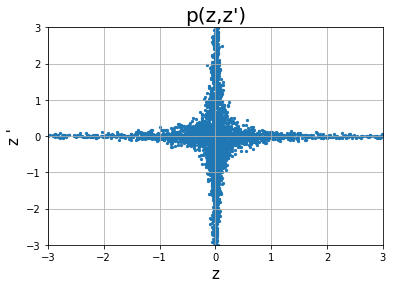

In [19]:
G,z1,z2,z1_prior,z2_prior = gibbs.calc(mu1,var1,mu2,var2,g11,g22)
z1_prior=z1_prior.cpu().detach().numpy()
z2_prior=z2_prior.cpu().detach().numpy()
x_val =[]
y_val =[]
#p(z,z') Gibbs sampling
for i in np.arange(5000):
    G,z1,z2,z1_prior,z2_prior = gibbs.calc(mu1,var1,mu2,var2,g11,g22)
    z1_prior=z1_prior.cpu().detach().numpy()
    z2_prior=z2_prior.cpu().detach().numpy()
    z1_prior=z1_prior.squeeze()
    z2_prior=z2_prior.squeeze()
    x_val=np.hstack((x_val,z1_prior))
    y_val=np.hstack((y_val,z2_prior))
plt.scatter(x_val,y_val,s=5)
plt.xlabel('z',fontsize=15)
plt.ylabel('z \'',fontsize=15)
plt.title('p(z,z\')',fontsize=20)
plt.xlim([-3, 3])
plt.ylim([-3, 3])

plt.grid()
plt.show()

I calculate the partition function of the prior by integrating the following function from -infinity to infinity
<span class="math display">
    \begin{aligned}
    \lambda(y,x)= \mathrm{exp}\left(-x^2-y^2+g_{11}xy-\mathrm{exp}(g_{22})x^2y^2\right)
    \end{aligned}
</span>

In [20]:
## Numerica integration of prior
g11=G[0,0].cpu().detach().numpy()
g11=float(g11)
g22=G[1,1].cpu().detach().numpy()
g22=float(g22)
f = lambda y, x: np.exp(-x**2 - y**2+g11*x*y-np.exp(g22)*(x**2)*(y**2))
val, err=integrate.dblquad(f, -np.inf, np.inf, lambda x: -np.inf, lambda x: np.inf)

I evaluate various points of the prior distribution using the formula,
<span class="math display">
    \begin{aligned}
    \mathrm{zlist}(x,y)= \frac{1}{\mathcal{Z}}\mathrm{exp}\left(-x^2-y^2+g_{11}xy-\mathrm{exp}(g_{22})x^2y^2\right)
    \end{aligned}
</span>

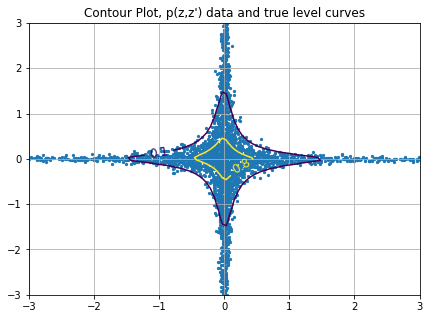

In [21]:
xlist = np.linspace(-3.0, 3.0, 100)
ylist = np.linspace(-3.0, 3.0, 100)
zlist = np.ndarray((100,100))
for x in range(0, len(xlist)):
    for y in range(0, len(ylist)):
        zlist[x][y] = 1/val*np.exp(-xlist[x]**2 - ylist[y]**2+g11*xlist[x]*ylist[y]-np.exp(g22)*(xlist[x]**2)*(ylist[y]**2))
levels=[0.1,0.8]
plt.figure(figsize=(7, 5))
plt.title('Contour Plot, p(z,z\') data and true level curves')
contours = plt.contour(xlist, ylist, zlist,levels)
plt.scatter(x_val,y_val,s=5)
plt.clabel(contours,inline=1,  fontsize=12)
plt.xlim([-3, 3])
plt.ylim([-3, 3])
plt.grid()
plt.show()

<ipython-input-33-62816b2b62d7>:19: UserWarning: No contour levels were found within the data range.
  contours=plt.contour(xx, yy, zz,levels)


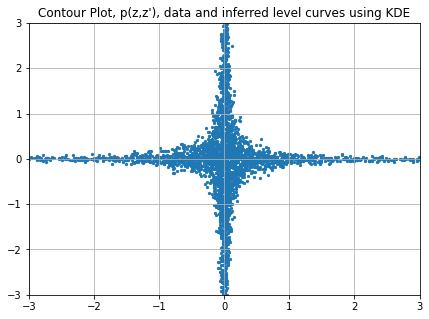

In [33]:
def kde2D(x, y, bandwidth, xbins=100j, ybins=100j, **kwargs): 
    """Build 2D kernel density estimate (KDE)."""
    # create grid of sample locations (default: 100x100)
    xx, yy = np.mgrid[x.min():x.max():xbins, 
                      y.min():y.max():ybins]

    xy_sample = np.vstack([yy.ravel(), xx.ravel()]).T
    xy_train  = np.vstack([y, x]).T

    kde_skl = KernelDensity(bandwidth=bandwidth, **kwargs)
    kde_skl.fit(xy_train)
    # score_samples() returns the log-likelihood of the samples
    z = np.exp(kde_skl.score_samples(xy_sample))
    return xx, yy, np.reshape(z, xx.shape)
levels=[0.01,0.08]
xx, yy, zz = kde2D(x_val, y_val, 0.06)
plt.figure(figsize=(7, 5))
plt.title('Contour Plot, p(z,z\'), data and inferred level curves using KDE')
contours=plt.contour(xx, yy, zz,levels)
plt.clabel(contours,inline=1,  fontsize=12)
plt.xlim([-3, 3])
plt.ylim([-3, 3])
plt.scatter(x_val, y_val, s=5)
plt.grid()
plt.show()

In [29]:
contours

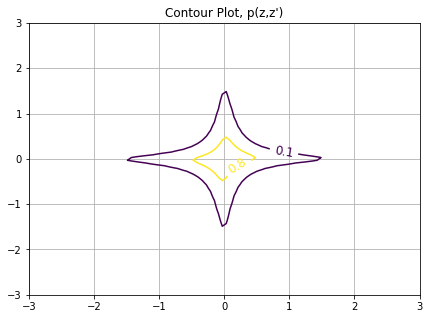

In [9]:
plt.figure(figsize=(7, 5))
plt.title('Contour Plot, p(z,z\')')
contours = plt.contour(xlist, ylist, zlist,levels)
plt.clabel(contours,inline=1,  fontsize=12)
plt.grid()
plt.show()

In [ ]:
#q(z,z'|x,x')
x_val =[]
y_val =[]
mu1=torch.tensor(1)
var1=torch.tensor(2)
mu2=torch.tensor(1)
var2=torch.tensor(2)
g11=torch.randn(1,1).to(device)
g22=(torch.randn(1,1)+5).to(device)
for i in np.arange(5000):
    G,z1,z2,z1_prior,z2_prior = gibbs.calc(mu1,var1,mu2,var2,g11,g22)
    z1=z1.cpu().detach().numpy()
    z2=z2.cpu().detach().numpy()
    z1=z1.squeeze()
    z2=z2.squeeze()
    x_val=np.hstack((x_val,z1))
    y_val=np.hstack((y_val,z2))
plt.scatter(x_val,y_val,s=5)
plt.xlabel('z',fontsize=15)
plt.ylabel('z \'',fontsize=15)
plt.title('q(z,z\'|x,x\')',fontsize=20)
plt.grid()
plt.show()
np.size(x_val)

In [22]:
## Numerica integration of posterior
g11=G[0,0].cpu().detach().numpy()
g11=float(g11)
g22=G[1,1].cpu().detach().numpy()
g22=float(g22)
f1 = lambda y, x: np.exp(-x**2 - y**2+g11*x*y-np.exp(g22)*(x**2)*(y**2)+(mu1*x-np.exp(var1)*x**2)+(mu2*y-np.exp(var2)*y**2))
val, err=integrate.dblquad(f1, -np.inf, np.inf, lambda x: -np.inf, lambda x: np.inf)

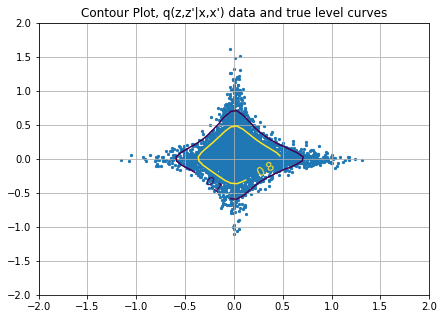

In [25]:
xlist = np.linspace(-3.0, 3.0, 100)
ylist = np.linspace(-3.0, 3.0, 100)
zlist = np.ndarray((100,100))
for x in range(0, len(xlist)):
    for y in range(0, len(ylist)):
        zlist[x][y] = 1/val*np.exp(-xlist[x]**2 - ylist[y]**2+g11*xlist[x]*ylist[y]-np.exp(g22)*(xlist[x]**2)*(ylist[y]**2)+(mu1*xlist[x]-np.exp(var1)*xlist[x]**2)+(mu2*ylist[y]-np.exp(var2)*ylist[y]**2))
plt.figure(figsize=(7, 5))
plt.title('Contour Plot, q(z,z\'|x,x\') data and true level curves')
contours = plt.contour(xlist, ylist, zlist,levels)
plt.scatter(x_val,y_val,s=5)
plt.clabel(contours,inline=1,  fontsize=12)
plt.xlim([-2,2])
plt.ylim([-2,2])

plt.grid()
plt.show()

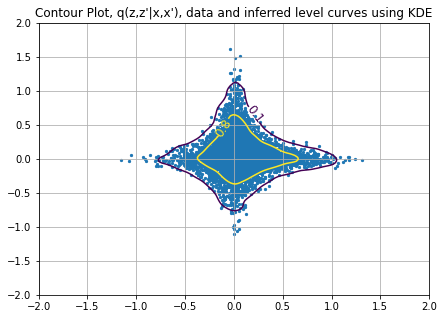

In [32]:
levels=[0.1,0.8]
xx, yy, zz = kde2D(x_val, y_val, 0.06)
plt.figure(figsize=(7, 5))
plt.title('Contour Plot, q(z,z\'|x,x\'), data and inferred level curves using KDE')
contours=plt.contour(xx, yy, zz,levels)
plt.clabel(contours,inline=1,  fontsize=12)
plt.xlim([-2, 2])
plt.ylim([-2, 2])
plt.scatter(x_val, y_val, s=5)
plt.grid()
plt.show()

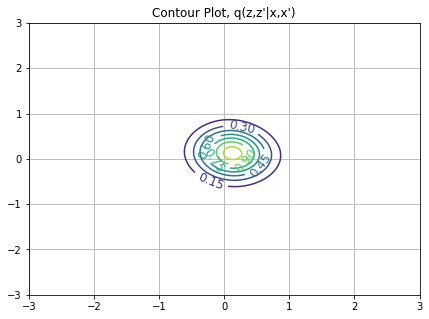

In [86]:
plt.figure(figsize=(7, 5))
plt.title('Contour Plot, q(z,z\'|x,x\')')
contours = plt.contour(xlist, ylist, zlist)
plt.clabel(contours,inline=1,  fontsize=12)
plt.grid()
plt.show()

<ipython-input-5-4a4e3794c82b>:30: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, zz)


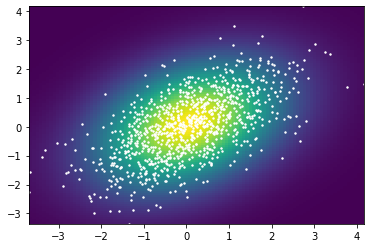

In [5]:
from sklearn.neighbors import KernelDensity
import numpy as np
import matplotlib.pyplot as plt

def kde2D(x, y, bandwidth, xbins=100j, ybins=100j, **kwargs): 
    """Build 2D kernel density estimate (KDE)."""

    # create grid of sample locations (default: 100x100)
    xx, yy = np.mgrid[x.min():x.max():xbins, 
                      y.min():y.max():ybins]

    xy_sample = np.vstack([yy.ravel(), xx.ravel()]).T
    xy_train  = np.vstack([y, x]).T

    kde_skl = KernelDensity(bandwidth=bandwidth, **kwargs)
    kde_skl.fit(xy_train)

    # score_samples() returns the log-likelihood of the samples
    z = np.exp(kde_skl.score_samples(xy_sample))
    return xx, yy, np.reshape(z, xx.shape)


m1 = np.random.normal(size=1000)
m2 = np.random.normal(scale=0.5, size=1000)

x, y = m1 + m2, m1 - m2

xx, yy, zz = kde2D(x, y, 1.0)

plt.pcolormesh(xx, yy, zz)
plt.scatter(x, y, s=2, facecolor='white')